In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Create engin and reflect an existing database into a new model
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

measurement_df = pd.read_sql("SELECT * FROM measurement", engine)

#Change date to datetime object, sort and set as index to pull last 12 months/365 days of data
measurement_df['date'] = pd.to_datetime(measurement_df.date)
measurement_df= measurement_df.sort_values(by='date').set_index('date')
past_12_months = measurement_df.last('365D')
past_12_months = past_12_months.reset_index()
past_12_months


,date,id,station,prcp,tobs
0,2016-08-24,19203,USC00516128,1.45,74.0
1,2016-08-24,2365,USC00519397,0.08,79.0
2,2016-08-24,5092,USC00513117,2.15,76.0
3,2016-08-24,14609,USC00519281,2.15,77.0
4,2016-08-24,8826,USC00517948,NaN,78.0
...,...,...,...,...,...
2218,2017-08-22,19549,USC00516128,0.50,76.0
2219,2017-08-23,2724,USC00519397,0.00,81.0
2220,2017-08-23,7635,USC00514830,0.00,82.0
2221,2017-08-23,12187,USC00519523,0.08,82.0


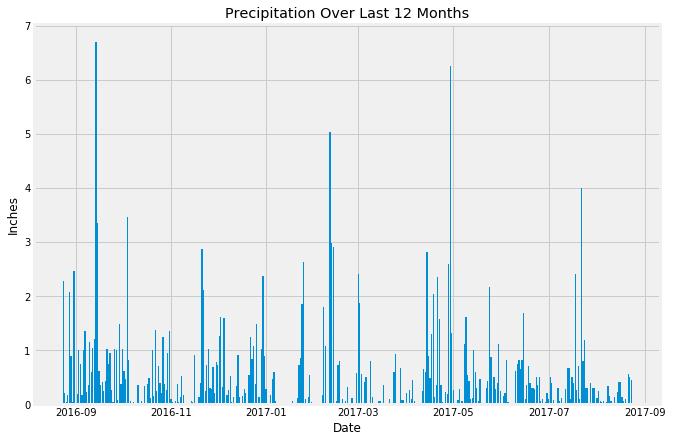

In [9]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10,7))
plt.bar(past_12_months['date'], past_12_months['prcp'])
plt.title('Precipitation Over Last 12 Months')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
past_12_months['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [11]:
# Design a query to show how many stations are available in this dataset
query = '''
SELECT COUNT(id) as count FROM station
'''

station_count = pd.read_sql(query, engine)
station_count['count'][0]

9

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = '''
SELECT 
    station, 
    COUNT(station) as Count 
FROM measurement
GROUP BY station
ORDER BY Count DESC
'''

active_stations = pd.read_sql(query, engine)
active_stations

,station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [13]:
# Calculate the lowest temperature recorded, highest temperature recorded, 
# and average temperature of the most active station?
query = '''
SELECT
	station,
	MIN(tobs) as minTemp,
	MAX(tobs) as maxTemp,
	AVG(tobs) as avgTemp
FROM measurement
WHERE station IN
(SELECT station FROM
(SELECT station, max(count) FROM
	(SELECT 
		station,
		count(station) as count
	FROM measurement
	GROUP BY station)))
'''

most_active_station_temps = pd.read_sql(query, engine)
most_active_station_temps

,station,minTemp,maxTemp,avgTemp
0,USC00519281,54.0,85.0,71.663781


In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = most_active_station_temps['station'][0]

most_active_station_df = pd.read_sql(f"SELECT * FROM measurement WHERE station = '{most_active_station}'", engine)

#Change date to datetime object, sort and set as index to pull last 12 months/365 days of data
most_active_station_df['date'] = pd.to_datetime(most_active_station_df.date)
most_active_station_df= most_active_station_df.sort_values(by='date').set_index('date')
most_active_past_12_months = most_active_station_df.last('365D')
most_active_past_12_months = most_active_past_12_months.reset_index()
most_active_past_12_months

,date,id,station,prcp,tobs
0,2016-08-19,14604,USC00519281,0.31,79.0
1,2016-08-20,14605,USC00519281,0.13,81.0
2,2016-08-21,14606,USC00519281,0.08,79.0
3,2016-08-22,14607,USC00519281,2.32,78.0
4,2016-08-23,14608,USC00519281,1.79,77.0
...,...,...,...,...,...
351,2017-08-14,14955,USC00519281,0.00,77.0
352,2017-08-15,14956,USC00519281,0.32,77.0
353,2017-08-16,14957,USC00519281,0.12,76.0
354,2017-08-17,14958,USC00519281,0.01,76.0


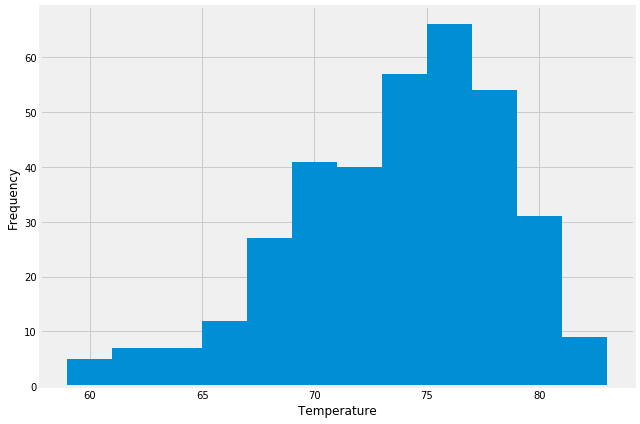

In [15]:
# Plot the results as a histogram

fig, ax = plt.subplots(figsize=(9,6))
plt.hist(most_active_past_12_months['tobs'],12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.tight_layout()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

In [17]:
# calculate the temps for your "current" and previous year's data for those same dates.
current = calc_temps('2016-06-10', '2016-06-20')
previous = calc_temps('2015-06-10', '2015-06-20')
previous

[(66.0, 74.87179487179488, 80.0)]

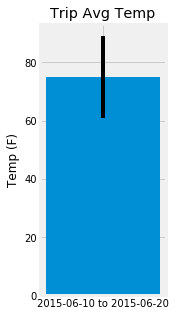

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

date = '2015-06-10 to 2015-06-20'
avg_temp = previous[0][1]
min_temp = previous[0][0]
max_temp = previous[0][2]
yerr= max_temp-min_temp

fig, ax = plt.subplots(figsize=(2,5))
plt.bar(date, avg_temp, yerr=yerr)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query ='''
SELECT m.station, sum(prcp) as total_prcp, latitude, longitude, elevation
FROM measurement m
JOIN station s ON m.station = s.station
WHERE date >= '2015-06-10' AND date <= '2015-06-20'
GROUP BY m.station
ORDER BY total_prcp
'''
rainfall_by_station = pd.read_sql(query, engine)
rainfall_by_station

,station,total_prcp,latitude,longitude,elevation
0,USC00517948,0.05,21.39340,-157.97510,11.9
1,USC00519397,0.08,21.27160,-157.81680,3.0
2,USC00511918,0.20,21.31520,-157.99920,0.9
3,USC00519523,0.23,21.33556,-157.71139,19.5
4,USC00514830,0.31,21.52130,-157.83740,7.0
5,USC00513117,0.83,21.42340,-157.80150,14.6
6,USC00519281,1.16,21.45167,-157.84889,32.9
7,USC00516128,3.96,21.33310,-157.80250,152.4


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("06-10")

[(68.0, 75.14285714285714, 81.0)]

In [21]:
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
date_range = pd.date_range(start='2015-06-10', end='2015-06-20')

dates = []
full_date = []

for x in date_range:
    day = x.strftime('%d')
    month = x.strftime('%m')
    year = x.strftime('%Y')
    dates.append(f"{month}-{day}")
    full_date.append(f"{year}-{month}-{day}")
   
    
# Loop through the list days and calculate the normals for each date
min_temp = []
max_temp = []
avg_temp = []


for date in dates:
   min_temp.append(daily_normals(date)[0][0])
   avg_temp.append(daily_normals(date)[0][1])
   max_temp.append(daily_normals(date)[0][2])


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_dic = {'Date': full_date,'Min Temp': min_temp, 'Avg Temp': avg_temp, 'Max Temp': max_temp}

normals_df = pd.DataFrame(normals_dic)
normals_df

,Date,Min Temp,Avg Temp,Max Temp
0,2015-06-10,68.0,75.142857,81.0
1,2015-06-11,69.0,76.019608,84.0
2,2015-06-12,66.0,75.666667,83.0
3,2015-06-13,68.0,75.666667,81.0
4,2015-06-14,69.0,75.627119,81.0
5,2015-06-15,67.0,75.403509,81.0
6,2015-06-16,69.0,75.413793,81.0
7,2015-06-17,68.0,74.593220,81.0
8,2015-06-18,69.0,74.603448,80.0
9,2015-06-19,70.0,75.440678,82.0


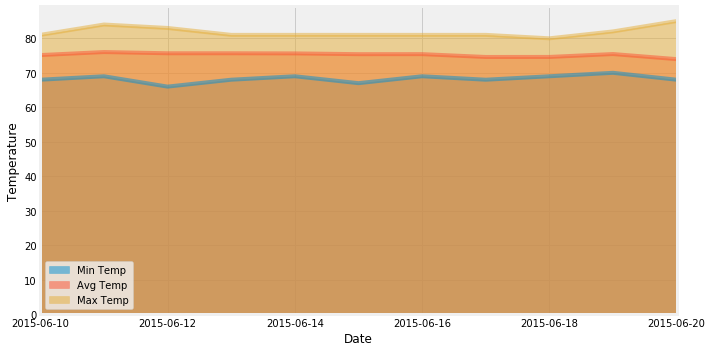

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(x='Date', kind='area', stacked=False, figsize=(10,5))
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.tight_layout()